In [1]:
!uv sync
%load_ext autoreload 
%autoreload 2  
# imported functions are re-imported if they are changed

Resolved 153 packages in 6ms
Audited 150 packages in 0.47ms


In [2]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import earthaccess

/Users/luke/Work/Students/benedict_ejelonu/data-exploration/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
auth = earthaccess.login(persist=True)

In [353]:
bbox_WSEN = 17.896010,-34.484990,19.598891,-33.159334  

results = earthaccess.search_data(
    short_name='MYD11_L2',
    temporal=('2020-01-01', '2020-01-31'),
    bounding_box=bbox_WSEN,
)

In [354]:
fnames = earthaccess.download(results, local_path='../data/modis_L2')

QUEUEING TASKS | : 100%|██████████| 78/78 [00:00<00:00, 31300.78it/s]
PROCESSING TASKS | : 100%|██████████| 78/78 [00:00<00:00, 722198.04it/s]
COLLECTING RESULTS | : 100%|██████████| 78/78 [00:00<00:00, 1627640.36it/s]


In [355]:
import pyhdf
import pyhdf.SD

def read_modis_core_metadata(dataset: pyhdf.SD.SD):
    import munch

    attrs = dataset.attributes()
    metadata = attrs['CoreMetadata.0']

    # convert string to a dictionary
    lines = metadata.splitlines()

    groups = {}
    for line in lines:
        line = line.strip()
        if '=' in line:
            key, value = line.split(' = ')
            key = key.strip()
            value = value.strip()
            if key == 'GROUP':
                group = value
                groups[group] = {}
            if key == 'OBJECT':
                object = value
                groups[group][object] = None
            if key == 'VALUE':
                groups[group][object] = value.replace('"', '')
    groups = munch.munchify(groups)
    return groups


def get_modis_image_datetime(dataset: pyhdf.SD.SD):
    meta = read_modis_core_metadata(dataset)

    datetime = meta.RANGEDATETIME
    start_date = datetime.RANGEBEGINNINGDATE
    start_time = datetime.RANGEBEGINNINGTIME
    end_date = datetime.RANGEENDINGDATE
    end_time = datetime.RANGEENDINGTIME

    start_datetime = pd.to_datetime(f'{start_date} {start_time}')
    end_datetime = pd.to_datetime(f'{end_date} {end_time}')

    return pd.DatetimeIndex([start_datetime, end_datetime])


def get_modis_variables(ds):
    
    datasets = ds.datasets()
    
    variables = {}
    for key, value in datasets.items():
        variables[key] = value[-1]

    return variables


def hdfsd_to_xarray(hdf_sd: pyhdf.SD.SDS):
    import numpy as np
    import xarray as xr

    data = hdf_sd.get()
    data = data.astype(float)
    data[data == hdf_sd.getfillvalue()] = np.nan

    attrs = hdf_sd.attributes()
    attrs = {key: value for key, value in attrs.items() if key not in ['_FillValue']}
    da = xr.DataArray(data, dims=['y', 'x'])

    da = da * attrs.get('scale_factor', 1) + attrs.get('add_offset', 0)
    
    attrs.pop('scale_factor', None)
    attrs.pop('add_offset', None)
    da.attrs = attrs

    return da


def hdf_modis_to_xarray(ds):
    import numpy as np
    import xarray as xr

    time = get_modis_image_datetime(ds)

    lst = hdfsd_to_xarray(ds.select('LST'))
    lat = hdfsd_to_xarray(ds.select('Latitude'))
    lon = hdfsd_to_xarray(ds.select('Longitude'))

    lst = lst.assign_coords(
        y=np.arange(0, lst.y.size), 
        x=np.arange(0, lst.x.size))

    lat = lat.assign_coords(
        y=np.arange(0, lst.y.size, 5), 
        x=np.arange(0, lst.x.size, 5)).interp_like(lst).bfill('y').ffill('y').bfill('x').ffill('x')

    lon = lon.assign_coords(
        y=np.arange(0, lst.y.size, 5), 
        x=np.arange(0, lst.x.size, 5)).interp_like(lst).bfill('y').ffill('y').bfill('x').ffill('x')

    out = xr.Dataset()
    out['lst'] = lst
    for key in ['QC', 'View_angle', 'View_time', 'Error_LST', 'Emis_31', 'Emis_32']:
        da = hdfsd_to_xarray(ds.select(key))
        out[key.lower()] = (
            da
            .assign_coords(lat=lat, lon=lon)
            .dropna('x', how='all')
            .dropna('y', how='all'))
    time = get_modis_image_datetime(ds)
    out = out.expand_dims(time=[time.mean()])
        
    return out

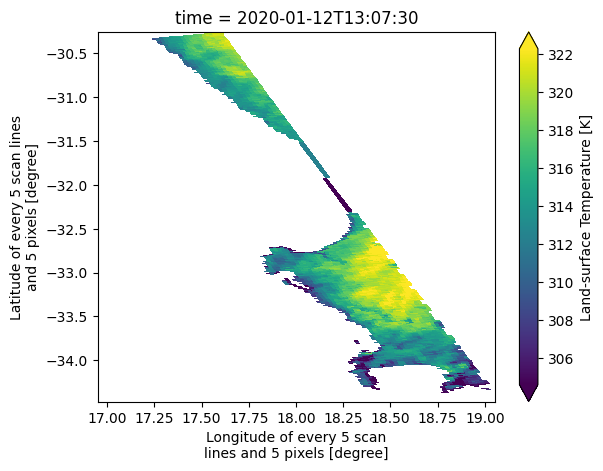

In [356]:
t = 29
ds = pyhdf.SD.SD(fnames[t])
out = hdf_modis_to_xarray(ds)

da = out.lst.where(out.view_angle < 45).dropna('x', how='all').dropna('y', how='all')
da.plot(x='lon', y='lat', robust=True)

img.axes.set_aspect('equal')

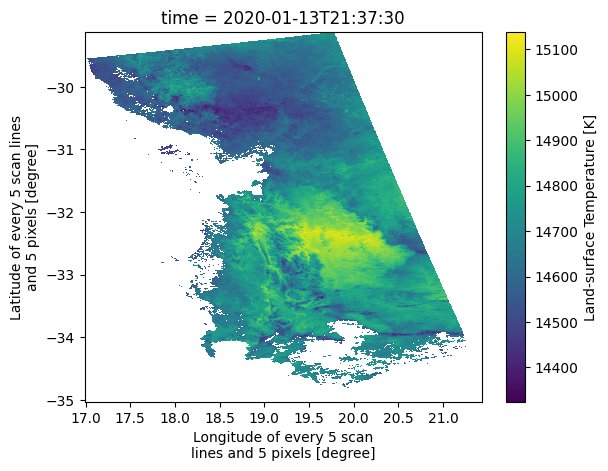